In [1]:
# Import libraries
import pandas as pd
import numpy as np
import re
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.core.display import display, HTML

plt.style.use('ggplot')

In [2]:
# Load hotel data from json file (scraped from hotels.com) and do some light preprocessing.
def read_json(filename):
    """
    Reads json file with hotel data and concatenates the result
    into one dataframe.
    """
    with open(filename, "rb") as f:
        data = json.load(f)

    dfs = [pd.DataFrame(item) for item in data]
    return pd.concat(dfs, ignore_index=True)

def extract_from_strings(df):
    """
    Finds values of interest in strings. Extract, and possibly split into new columns.
    """
    df_ = df.copy()
    price = []
    price_sale = []
    
    # Extract dollar amounts from string
    df_["price"] = df_.price.str.findall(r"(\$\d+)")

    # Extract numeric values in strings
    df_["rating"] = df_.rating.str.extract(r"(\d+\.*\d*)").astype(float)
    df_["n_reviews"] = df_.n_reviews.str.replace(",","").str.extract(r"(\d+)").astype(int)
    df_["star_rating"] = df_.star_rating.str.extract(r"(\d+\.*\d*)").astype(float)
    
    for row_ in df_.iterrows():
        # Split dollar amounts into two columns (`price`and ´price_sale`)
        row = row_[1]["price"]
        if not row:
            price.append(None)
            price_sale.append(None)
        elif len(row) == 1:
            price.append(int(row[0].lstrip("$")))
            price_sale.append(None)
        elif len(row) == 2:
            price.append(int(row[0].lstrip("$")))
            price_sale.append(int(row[1].lstrip("$")))
        
    df_["price"] = price
    df_["price_sale"] = price_sale
    return df_

def preprocess(df):
    """
    Runs a set of preprocessing actions. 
    """
    
    # Drop columns
    drop_cols = ["adults", "children", "address", "review_box"]

    # Cast date columns as datetime
    df["checkin"] = pd.to_datetime(df["checkin"])
    df["checkout"] = pd.to_datetime(df["checkout"])
    df = df.drop(columns=drop_cols)
    
    # Extract data from string fields
    df = extract_from_strings(df)
    return df

def n_lowest_prices(df, column, n=3):
    return df.nsmallest(n, column)

def display_side_by_side(dfs, captions, padding=1):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += padding * "\xa0"
    display(HTML(output))

In [3]:
class GridPlot(object):
    """
    Helper class for plotting multiple datasets superimposed and/or as subplots in a grid.
    
    Args:
        data (dict): Data dictionary with optional plotting options.
        grid (tuple, optional): Tuple indicating figure grid size. Defaults to (1,).
            
    Example:
        x = [0,1,2,3,4,5]
        y1 = [10,8,5,6,9,12]
        y2 = [9,6,4,5,2,1]
        X = (x, x)
        X = (y1, y2)
        data = dict(
            # Figure that will appear in place 0 in the figure grid
            0 = {"x": X,
                "y": Y, 
                "plot_options": [
                    {"label": "label of y1 data"},
                    {"label": "label of y2 data"},
                    ],
                "ax_options": {
                    "legend": True, 
                    "ylabel": "y-axis name", 
                    "xlabel": "x-axis name", 
                    "title": "figure title"}
                },
            # Figure that will appear in place 1 in the figure grid
            1 = {"x": x, 
                "y": y1, 
                "plot_options": [
                    {"label": "label of y1 data"},
                    ],
                "ax_options": {
                    "legend": True, 
                    "ylabel": "y-axis name", 
                    "xlabel": "x-axis name", 
                    "title": "figure title"}
                },
        gp = GridPlot()
        gp.plot()
    """
    
    def __init__(self, data, grid=(1,1)):
        
        if not isinstance(data, list):
            data = [data]
        self.data = data
        self.axgrid = grid
        # assert len(self.data) == sum(self.axgrid), f"data must be of size n_plots ({len(data)} != {self.axgrid})"

    def plot(self, figsize=(8,6), sharex=True, sharey=False):
        """
        Creates the plots.
        
        Args:
            figsize (tuple): Tuple of size 2 indicating the figure size. Defaults to (8,6).
        """
        
        # Set up the axes with gridspec
        fig, axes = plt.subplots(*self.axgrid, figsize=figsize, sharex=sharex, sharey=sharey)
        
        if not isinstance(axes, np.ndarray):
            axes = [axes]
        else:
            axes = axes.flatten()
        for i, ax in enumerate(axes):
            data = self.data[i] #.get(i)
            x = data.get("x")
            y = data.get("y")
            plot_options = data.get("plot_options")
            ax_options = data.get("ax_options")

            if not isinstance(x, (tuple)):
                x = tuple([x])
            if not isinstance(y, (tuple)):
                y = tuple([y])
            if not isinstance(plot_options, (list)):
                plot_options = [plot_options]
                
            for xvals, yvals, plot_opts in zip(x, y, plot_options):
                ax.plot(xvals, yvals, **plot_opts)

            label_size = ax_options.get("label_size", 20)
            
            if "legend" in ax_options:
                ax.legend(fontsize=14)
            if "title" in ax_options:
                ax.set_title(ax_options.get("title"), size=label_size)
            if "xlabel" in ax_options:
                ax.set_xlabel(ax_options.get("xlabel"), size=label_size)
            if "ylabel" in ax_options:
                ax.set_ylabel(ax_options.get("ylabel"), size=label_size)
                
            # We change the fontsize of minor ticks label 
            ax.tick_params(axis='both', which='major', labelsize=14)
            ax.tick_params(axis='both', which='minor', labelsize=14)
        fig.tight_layout()
    

# Predicting Hotel Prices





Jakob Calvén

##### Imagine for a moment that you would like to book a room in a 4-star hotel in Las Vegas on July 25th. 

#### When should you book to get the best price?



- Hotel prices are dynamic and difficult to predict – puts consumers at a disadvantage


- Data driven price prediction takes away the guesswork, and 

    <h1><strong><em>Empowers the Consumer</em></strong></h1>
    
    The mission of this project.


# Challenges

#### Data
- How to get it?

#### Modeling
- Complex pricing structure
    - Many factors influencing pricing, e.g. demand, season, day of week, external events
    - Pricing strategies varies across hotels
    

# Data - How to get it?

- Publicly available data of historical price averages
- No publicly available data with historical hotel prices for specific search dates

- Need to gather the data ourselves
    - Global Distribution Systems (GDS)
        - API &#128077;   Pricey &#128078;
        - API the only way to get the data &#128078;
    - Booking sites
        - API &#128077;   Pricey &#128078;
        
        - <span style="color:green">Possible to scrape &#128077;  Free! &#128077;</span>

# Data - How to get it?

- Cron job runs a Python script that scrapes a hotel site daily at a set time
    - Prices for 1 night in a standard room in all hotels with availability up to 6 months in the future are scraped
    - Almost 2 months worth of data by the start of program. 4 months by the time it ends
    + More data translates to better models
    - Each daily dataset ~30MB


# Raw data

In [4]:
# Read hotel data
df = read_json('./data/hotels_vegas.json')
df.head(2)

,name,address,hotel_details,review_box,rating,n_reviews,price,checkin,checkout,adults,children,star_rating
0,Royal Resort,"99 Convention Center Dr, Las Vegas, NV, 89109,...",3.5-starLas Vegas1.3 miles to City center0.6 m...,3.5-starLas Vegas1.3 miles to City center0.6 m...,7.2 Good,367 reviews,$47The struck out price is based on the proper...,2020-05-05,2020-05-06,2,0,3.5-star
1,Fairfield Inn Las Vegas Convention Center,"3850 Paradise Rd, Las Vegas, NV, 89109, United...",2.5-starLas Vegas1.0 mile to City center0.9 mi...,2.5-starLas Vegas1.0 mile to City center0.9 mi...,8.6 Fabulous,271 reviews,Great Rate*$189The price comparison is based o...,2020-05-05,2020-05-06,2,0,2.5-star


# Cleaned up

In [5]:
df = preprocess(df)
df.head(2)

,name,hotel_details,rating,n_reviews,price,checkin,checkout,star_rating,price_sale
0,Royal Resort,3.5-starLas Vegas1.3 miles to City center0.6 m...,7.2,367,47.0,2020-05-05,2020-05-06,3.5,42.0
1,Fairfield Inn Las Vegas Convention Center,2.5-starLas Vegas1.0 mile to City center0.9 mi...,8.6,271,189.0,2020-05-05,2020-05-06,2.5,99.0


# Challenges

#### Data
- How to get it?

#### Modeling
- Complex pricing structure
    - Many factors influencing pricing, e.g. demand, season, day of week, external events, location, randomness
    - Pricing strategies varies across hotels – one model may not fit them all
    

# Modeling – Complex pricing structure

In [6]:
# Historic hotel index for the months 2018-04 -- 2018-11 in Las Vegas
index_prices = pd.DataFrame({
    "month": ["2020-04-15", "2020-05-15", "2020-06-15", "2020-07-15", 
              "2020-08-15", "2020-09-15", "2020-10-15", "2020-11-15"], 
    "price": [120, 142, 108, 106, 114, 145, 150, 119],
})
index_prices["month"] = pd.to_datetime(index_prices.month)
# index_prices.plot("month", "price", legend=False)

# Interpolate between dates to get price on a daily basis
idx = pd.date_range('2020-04-15', '2020-11-15')
index_prices = index_prices.set_index("month")
index_prices = index_prices.reindex(idx, fill_value=np.nan)
index_prices["price"] = index_prices.price.interpolate(method="cubic")

# Calculate a price normalization factor for each month in the Price Index data set
index_prices["price_corr_factor"] = 1/(index_prices["price"] / index_prices["price"].mean())

index_prices = index_prices.reset_index().rename(columns={"index": "date"})

#ax = index_prices.plot("date", "price", legend=False, title="Index price")
#ax.set(xlabel="date", ylabel="price ($)")

#ax = index_prices.plot("date", "price_corr_factor", legend=False, title="Seasonal correction factor")
#ax.set(xlabel="date", ylabel="correction factor")

# Limit dates to the span 2020-05-05 – 2020-11-05
index_prices = index_prices.loc[(index_prices.date >= "2020-05-05") & (index_prices.date <= "2020-11-05")].reset_index()

In [7]:
plot_data = []

date_groups = df.groupby("checkin").mean().reset_index()
x = (
    date_groups["checkin"], 
    date_groups["checkin"], 
    index_prices["date"]
)
y = (
    date_groups["price"], 
    date_groups["price"]*index_prices["price_corr_factor"], 
    index_prices["price"]
)

plot_data.append({
    "x": x, 
    "y": y, 
    "plot_options": [
        {"label": "price", "alpha": 1},
        {"label": "corrected price", "alpha": 1},
        {"label": "average price (2018 data)"},
        ],
    "ax_options": {"legend": True, "ylabel": "price ($)", "xlabel": "date",
    "title": "Average price w/ seasonal correction"}
    })

#### Seasonal effect

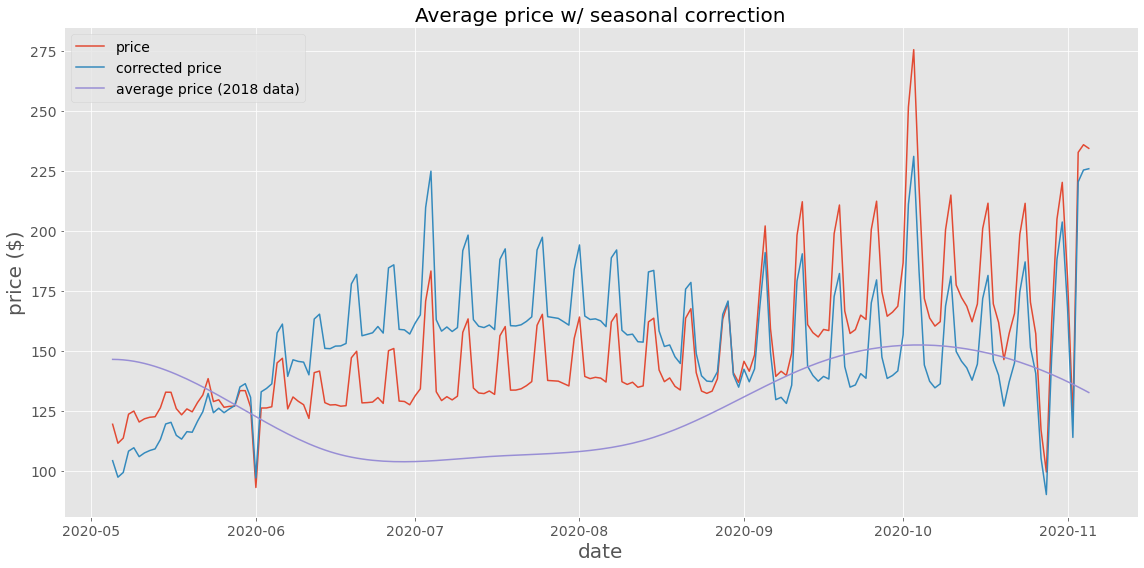

In [8]:
gp = GridPlot(plot_data, (1,1))
gp.plot(figsize=(16,8))

#plot_weekdays()

In [9]:
# Split hotels into 2, 3, 4 and 5-star categories
df_2star = df.loc[(df.star_rating >= 2) & (df.star_rating <= 2.5)]
df_3star = df.loc[(df.star_rating >= 3) & (df.star_rating <= 3.5)]
df_4star = df.loc[(df.star_rating >= 4) & (df.star_rating <= 4.5)]
df_5star = df.loc[(df.star_rating >= 5)]

In [10]:
plot_data = []

date_groups = df_2star.groupby("checkin").mean().reset_index()
x = date_groups["checkin"]
y = date_groups["price"]
plot_data.append({"x": x, "y": y, "plot_options": {"label": "price"},
 "ax_options": {"legend": True, "ylabel": "price ($)",# "xlabel": "date",
 "title": "Average price: 2-star hotels"}})

date_groups = df_3star.groupby("checkin").mean().reset_index()
x = date_groups["checkin"]
y = date_groups["price"]
plot_data.append({"x": x, "y": y, "plot_options": {"label": "price"}, "ax_options": {"legend": True, "ylabel": "price ($)",# "xlabel": "date",
 "title": "Average price: 3-star hotels"}})

date_groups = df_4star.groupby("checkin").mean().reset_index()
x = date_groups["checkin"]
y = date_groups["price"]
plot_data.append({"x": x, "y": y, "plot_options": {"label": "price"}, "ax_options": {"legend": True, "ylabel": "price ($)", "xlabel": "date",
 "title": "Average price: 4-star hotels"}})

date_groups = df_5star.groupby("checkin").mean().reset_index()
x = date_groups["checkin"]
y = date_groups["price"]
plot_data.append({"x": x, "y": y, "plot_options": {"label": "price"}, "ax_options": {"legend": True, "ylabel": "price ($)", "xlabel": "date",
 "title": "Average price: 5-star hotels"}})

#gp = GridPlot(plot_data, (2,2))
gp = GridPlot(plot_data, (2,2))
#gp.plot(figsize=(12, 8))

# Modeling – Complex pricing structure

#### Different behavior

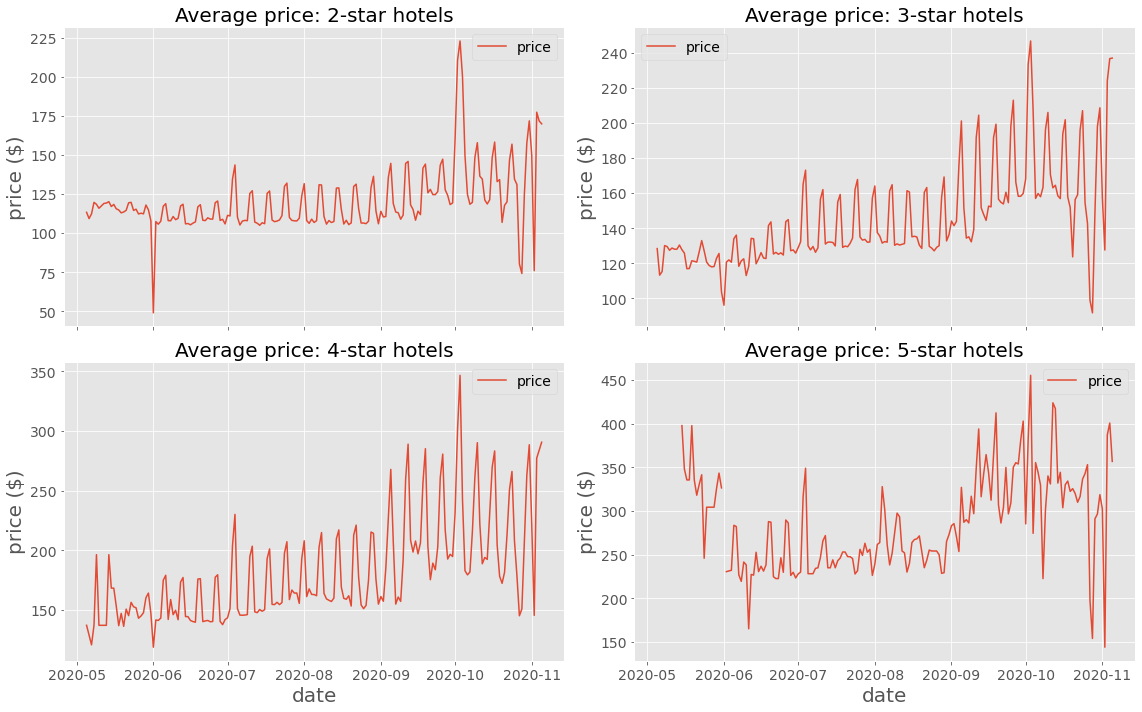

In [11]:
gp = GridPlot(plot_data, (2,2))
gp.plot(figsize=(16, 10))

# Plan

#### Data
- Keep collecting data
- Add 1 more city to collect data for

#### Modeling

- Start simple: linear regression, autogregressive models (e.g. ARIMA)
- More complex: temporal NNs (RNN, TCN)

# To summarize

- Goal: Predict if hotel prices will go &#11014; or &#11015;
- No existing data – need to collect our own by scraping booking sites
- Pricing data is complex – not one distribution for all hotels, seasonal and other effects
- Start with simple models – as more data is collected, use more complex models

### At the end of this project, I hope to be able to tell you when you should book that hotel room in Las Vegas.

# Questions?

# Extras

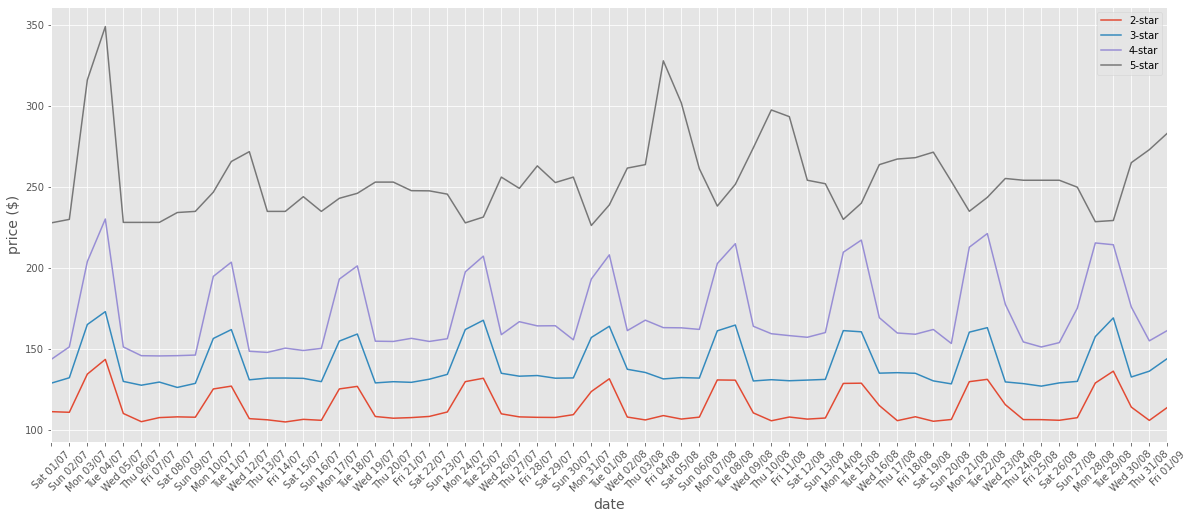

In [12]:
def daterange(df, startdate="2020-07-01", enddate="2020-09-01"):
    return df.loc[(df.checkin >= startdate) & (df.checkin <= enddate)]

fig, ax = plt.subplots(1, figsize=(20,8))

date_groups = daterange(df_2star.groupby("checkin").mean().reset_index())
_ = date_groups.plot(x='checkin', y='price', legend=True, ax=ax, label="2-star")

date_groups = daterange(df_3star.groupby("checkin").mean().reset_index())
_ = date_groups.plot(x='checkin', y='price', legend=True, ax=ax, label="3-star")

date_groups = daterange(df_4star.groupby("checkin").mean().reset_index())
_ = date_groups.plot(x='checkin', y='price', legend=True, ax=ax, label="4-star")

date_groups = daterange(df_5star.groupby("checkin").mean().reset_index())
_ = date_groups.plot(x='checkin', y='price', legend=True, ax=ax, label="5-star")

ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%a %d/%m'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %d/%m'))
ax.xaxis.grid(True, which='both')

plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

ax.set_xlabel("date", size=14)
ax.set_ylabel("price ($)", size=14);

In [13]:
star_groups = [df_2star, df_3star, df_4star, df_5star]

for i, g in enumerate(star_groups, 2):
    date_groups = g.groupby("checkin").mean().reset_index()
    date_groups["corr_price"] = (date_groups["price"]*index_prices["price_corr_factor"])
    
    df_lowest_list = [n_lowest_prices(date_groups, "price", 3)[["checkin", "price", "corr_price"]],
                      n_lowest_prices(date_groups, "corr_price", 3)[["checkin", "price", "corr_price"]]]
    
    captions_list = ["3 lowest prices", "3 lowest corrected prices"]
    
    print(f"\n{i}-star:")
    display_side_by_side(df_lowest_list, captions_list, padding=5)


2-star:


,checkin,price,corr_price
27,2020-06-01 00:00:00,49.000000,51.095892
176,2020-10-28 00:00:00,74.200000,67.217241
181,2020-11-02 00:00:00,76.000000,71.397198
,checkin,price,corr_price
27,2020-06-01 00:00:00,49.000000,51.095892
176,2020-10-28 00:00:00,74.200000,67.217241
181,2020-11-02 00:00:00,76.000000,71.397198



3-star:


,checkin,price,corr_price
176,2020-10-28 00:00:00,91.818182,83.177424
27,2020-06-01 00:00:00,96.166667,100.280033
175,2020-10-27 00:00:00,98.947368,89.066700
,checkin,price,corr_price
176,2020-10-28 00:00:00,91.818182,83.177424
175,2020-10-27 00:00:00,98.947368,89.066700
1,2020-05-06 00:00:00,113.277778,98.927795



4-star:


,checkin,price,corr_price
27,2020-06-01 00:00:00,119.000000,124.090024
2,2020-05-07 00:00:00,121.000000,105.778229
1,2020-05-06 00:00:00,129.000000,112.658333
,checkin,price,corr_price
2,2020-05-07 00:00:00,121.000000,105.778229
1,2020-05-06 00:00:00,129.000000,112.658333
0,2020-05-05 00:00:00,137.333333,119.896806



5-star:


,checkin,price,corr_price
181,2020-11-02 00:00:00,144.000000,135.278901
176,2020-10-28 00:00:00,154.000000,139.507481
37,2020-06-11 00:00:00,165.090909,189.666588
,checkin,price,corr_price
181,2020-11-02 00:00:00,144.000000,135.278901
176,2020-10-28 00:00:00,154.000000,139.507481
175,2020-10-27 00:00:00,197.333333,177.628058


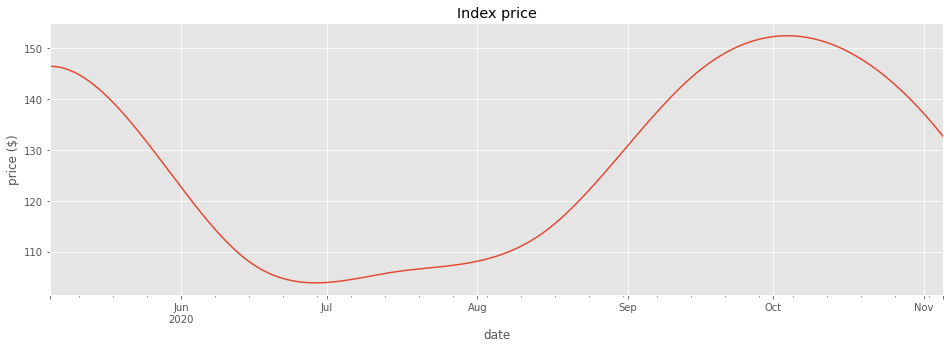

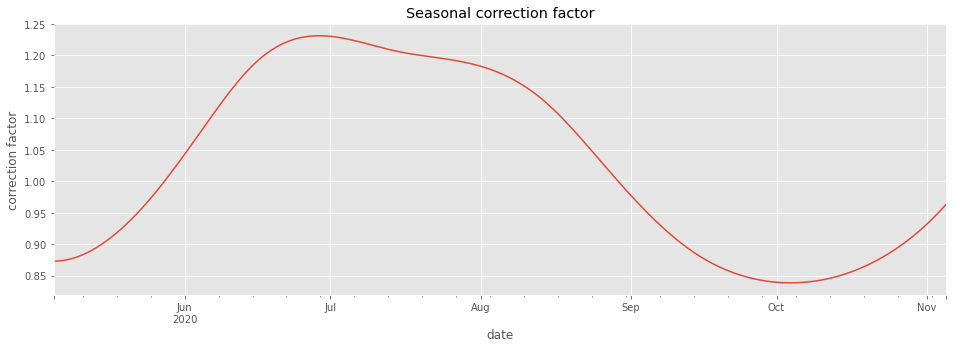

In [22]:
ax = index_prices.plot("date", "price", legend=False, title="Index price", figsize=(16,5))
ax.set(xlabel="date", ylabel="price ($)")

ax = index_prices.plot("date", "price_corr_factor", legend=False, title="Seasonal correction factor", figsize=(16,5))
ax.set(xlabel="date", ylabel="correction factor");